In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['ATEN_CPU_CAPABILITY'] = 'default'

In [11]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))

32033
15


In [18]:
# build the vocabulary of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [19]:
import random
random.seed(42)
random.shuffle(words)

In [101]:
# build the dataset
block_size = 8

def build_dataset(words):    
    X, Y = [], []
    for w in words:
        context= [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(itos[i] for i in context), '----->', itos[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182484, 8]) torch.Size([182484])
torch.Size([22869, 8]) torch.Size([22869])
torch.Size([22793, 8]) torch.Size([22793])


In [102]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[idx.item()] for idx in x), '---->', itos[y.item()])

........ ----> j
.......j ----> a
......ja ----> y
.....jay ----> r
....jayr ----> i
...jayri ----> e
..jayrie ----> l
.jayriel ----> .
........ ----> j
.......j ----> a
......ja ----> x
.....jax ----> l
....jaxl ----> y
...jaxly ----> n
..jaxlyn ----> n
.jaxlynn ----> .
........ ----> o
.......o ----> a
......oa ----> k
.....oak ----> l


In [103]:
# same as pt 3


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [104]:
torch.manual_seed(42)

In [105]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# param init
with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [91]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
        
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # keep stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2635
  10000/ 200000: 2.1982
  20000/ 200000: 1.9298
  30000/ 200000: 2.0323
  40000/ 200000: 2.0760
  50000/ 200000: 2.3116
  60000/ 200000: 2.2185
  70000/ 200000: 2.1055
  80000/ 200000: 1.8230
  90000/ 200000: 1.8200
 100000/ 200000: 1.8623
 110000/ 200000: 1.8979
 120000/ 200000: 2.4110
 130000/ 200000: 2.0708
 140000/ 200000: 2.3752
 150000/ 200000: 1.8911
 160000/ 200000: 2.0119
 170000/ 200000: 1.9385
 180000/ 200000: 2.1936
 190000/ 200000: 2.0652


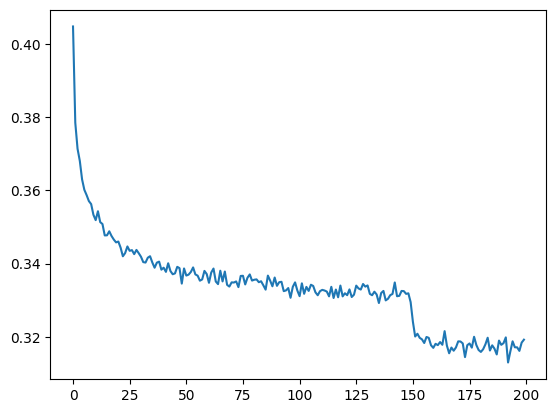

In [93]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [94]:
for layer in model.layers:
    layer.training = False

In [95]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte)
    }[split]
    emb = C[x]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.060253858566284
val 2.1107187271118164


In [96]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:        
        logits = model(torch.tensor([context]))       
        probs = F.softmax(logits, dim=1)
        # do the sampling
        idx = torch.multinomial( probs, num_samples=1).item()
        # shift the context window
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

fairiah.
nah.
hiriana.
chloluwa.
jotte.
jorgia.
shir.
arion.
kia.
fwyllas.
kamne.
gal.
nick.
aleniah.
cola.
karlaakyn.
joaklasiah.
rain.
aeryah.
natalain.
